In [1]:
!pip install tensorflow==2.3.1

In [2]:
!pip install tensorflow-quantum

In [3]:
!pip install cirq

In [4]:
import tensorflow as tf 
import tensorflow_quantum as tfq 
import cirq 
import sympy 
import numpy as np 
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


N total train:  60000
N total test:  10000
filtered N train: 12049
filtered N test: 1968


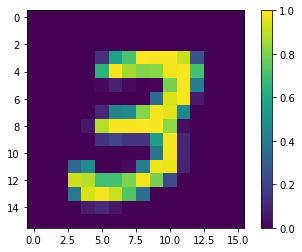

In [5]:
import collections 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("N total train: ", len(x_train))
print("N total test: ", len(x_test))

def filter_36(x,y):
  keep = (y==3)|(y==6)
  x, y = x[keep], y[keep]
  y = y == 3
  return x,y 

x_train_, y_train_ = filter_36(x_train, y_train)
x_test_, y_test_ = filter_36(x_test, y_test)

print('filtered N train:' , len(x_train_))
print('filtered N test:', len(x_test_))

x_train_small = tf.image.resize(x_train_, (16,16)).numpy()
x_test_small = tf.image.resize(x_test_, (16,16)).numpy()

def convert_label(y):
  if y==True:
    return 1.0
  else: 
    return -1.0  #changed from -1.0

y_train_ = [convert_label(y) for y in y_train_]
y_test_ = [convert_label(y) for y in y_test_]

plt.imshow(x_train_small[0,:,:,0], vmin = 0, vmax = 1 )
plt.colorbar()

X_train = x_train_small[:100]
X_test = x_test_small[:20]
Y_train = y_train_[:100]
Y_test = y_test_[:20]


In [6]:
#encode images to quantum states

def encode_all_data(values):
  #im4 = values[1:5,1:5]
  phi = np.ndarray.flatten(values)
  encode_circuit = cirq.Circuit()
  qubits = cirq.GridQubit.rect(16,16)
  for i in range(16*16):
    encode_circuit.append(cirq.ry(np.pi*phi[i])(qubits[i]))
  return encode_circuit 


In [7]:
#Try 4 qubit gates -- to be improved later

from sympy.physics.quantum import TensorProduct
class ZZZZ(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.ZZ),cirq.unitary(cirq.ZZ))**self.symbols
  def __str__(self):
    return 'ZZZZ'


class XXXX(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.XX),cirq.unitary(cirq.XX))**self.symbols
  def __str__(self):
    return 'XXXX'

class YYYY(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.YY),cirq.unitary(cirq.YY))**self.symbols
  def __str__(self):
    return 'YYYY'

In [8]:
def one_qubit_unitary(bit, symbols):
  """Rotation of bloch sphere about X, Y and Z axis, that depends on values in symbols"""
  return cirq.Circuit(
      cirq.X(bit)**symbols[0],
      cirq.Y(bit)**symbols[1],
      cirq.Z(bit)**symbols[2])
  
def conv_filter_4(bits, symbols):
  circuit=cirq.Circuit()
  """
  circuit += one_qubit_unitary(bits[0], symbols[0:3])
  circuit += one_qubit_unitary(bits[1], symbols[3:6])
  circuit += one_qubit_unitary(bits[2], symbols[6:9])
  circuit += one_qubit_unitary(bits[3], symbols[9:12])
  """
  
  for first, second in zip(bits[0::2], bits[1::2]):
    circuit += [cirq.ZZ(first, second)**symbols[0]]
    circuit += [cirq.YY(first, second)**symbols[1]]
    circuit += [cirq.XX(first, second)**symbols[2]]

  """
  circuit += one_qubit_unitary(bits[0], symbols[15:18])
  circuit += one_qubit_unitary(bits[1], symbols[18:21])
  circuit += one_qubit_unitary(bits[2], symbols[21:24])
  circuit += one_qubit_unitary(bits[3], symbols[24:])
  """
  
#pooling
  circuit+=cirq.CNOT(control=bits[0], target=bits[1])
  circuit+=cirq.CNOT(control=bits[2], target=bits[3])
  circuit+=cirq.CNOT(control=bits[1], target=bits[3])
  #circuit+=cirq.PauliSum(bits)

  return circuit 



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


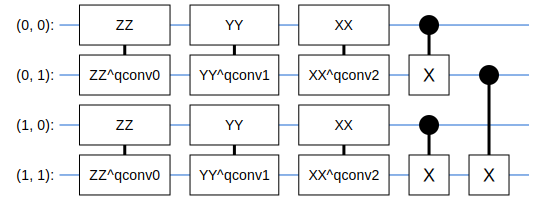

In [9]:
qubits = cirq.GridQubit.rect(2,2)
symbols = sympy.symbols('qconv0:100')
SVGCircuit(conv_filter_4(qubits, symbols))

In [10]:
def conv_circuit(bits, symbols):
  circuit = cirq.Circuit()
  n = int(np.sqrt(len(bits)))
  patch = np.array(bits).reshape((n,n))
  count = 0 

  #sliding 
  readouts=[]
  for j in range(0,n,2):
    for k in range(0,n,2):
      circuit+= conv_filter_4([patch[j,k], patch[j,k+1], patch[j+1, k], patch[j+1, k+1]], symbols[0:3])
      #circuit+= cirq.measure(patch[j+1, k+1])
      readouts.append(cirq.Z(patch[j+1, k+1]))
      count+=3
  return circuit, readouts


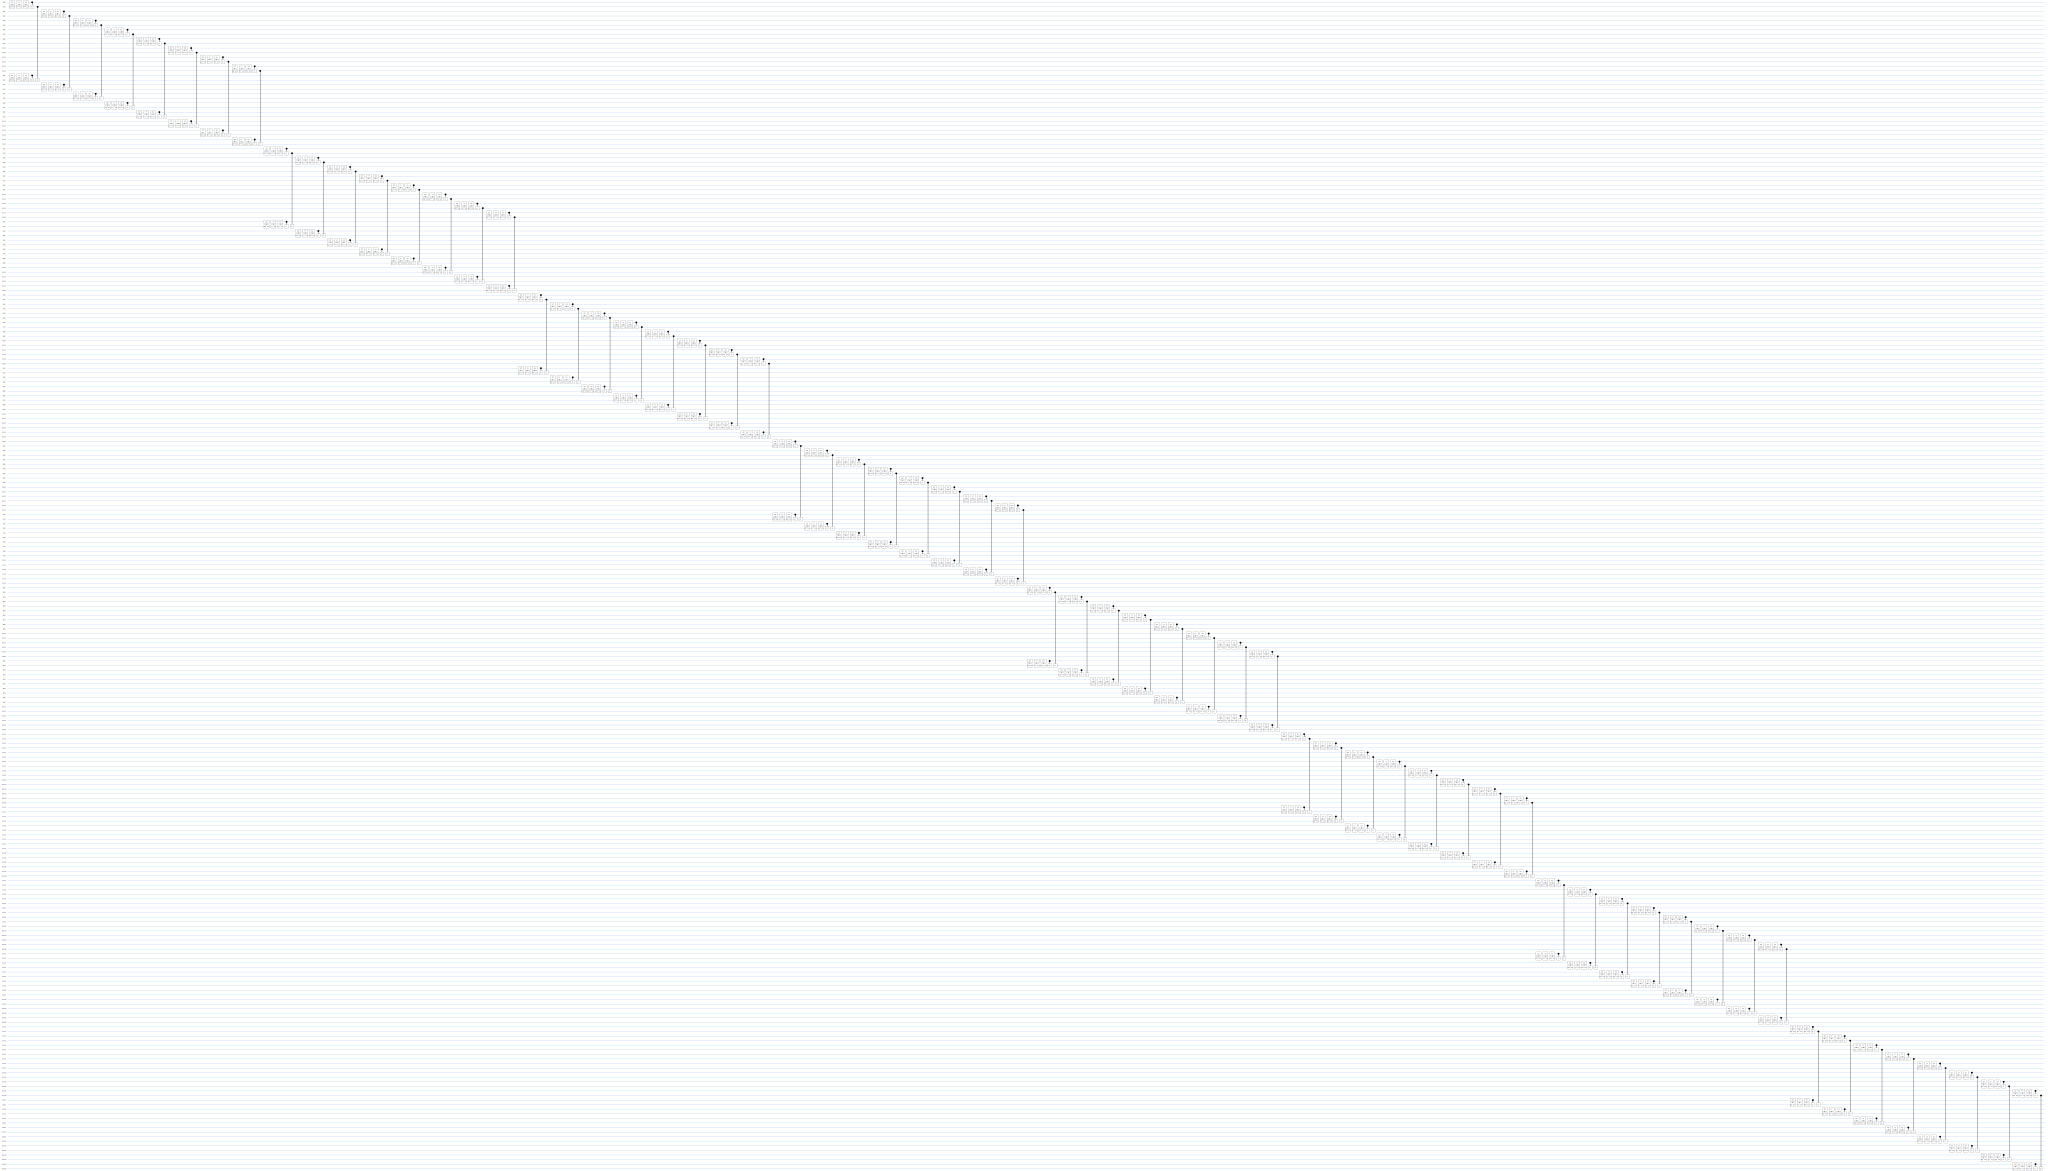

In [11]:
circ, read = conv_circuit(cirq.GridQubit.rect(16,16), sympy.symbols('x0:3'))
SVGCircuit(circ)


In [12]:
print(conv_circuit(cirq.GridQubit.rect(16,16), sympy.symbols('x0:500')))

(cirq.Circuit([
    cirq.Moment(
        (cirq.ZZ**sympy.Symbol('x0')).on(cirq.GridQubit(0, 0), cirq.GridQubit(0, 1)),
        (cirq.ZZ**sympy.Symbol('x0')).on(cirq.GridQubit(1, 0), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        (cirq.YY**sympy.Symbol('x1')).on(cirq.GridQubit(0, 0), cirq.GridQubit(0, 1)),
        (cirq.YY**sympy.Symbol('x1')).on(cirq.GridQubit(1, 0), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        (cirq.XX**sympy.Symbol('x2')).on(cirq.GridQubit(0, 0), cirq.GridQubit(0, 1)),
        (cirq.XX**sympy.Symbol('x2')).on(cirq.GridQubit(1, 0), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(0, 0), cirq.GridQubit(0, 1)),
        cirq.CNOT(cirq.GridQubit(1, 0), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        (cirq.ZZ**sympy.Symbol('x0')).on(cirq.GridQubit(0, 2), cirq.GridQubit(0, 3)),
        (cirq.ZZ**sympy.Symbol('x0')).on(cirq.GridQubit(

In [13]:
def create_model(qubits):
  #readout_operators = []
  model_circuit = cirq.Circuit()
  symbols = sympy.symbols('qconv0:3')
  layer, readouts= conv_circuit(qubits, symbols[:192])
  model_circuit+=layer
  #readout_operators.append(readouts)
  return model_circuit, readouts





In [14]:
def find_readouts(qubits):
  n = int(np.sqrt(len(qubits)))
  qubits_tiled = np.array(qubits).reshape((n,n))
  next_qubits = []
  for j in range(0,n,2):
    for k in range(0,n,2):
      next_qubits.append(qubits_tiled[j+1, k+1])

  return next_qubits



In [15]:
qubits1616 = cirq.GridQubit.rect(16,16)

qubits_l1 = qubits1616
qubits_l2 = find_readouts(qubits_l1)
qubits_l3 = find_readouts(qubits_l2)
qubits_l4 = find_readouts(qubits_l3)
qubits_l5 = find_readouts(qubits_l4)

In [17]:
circuit_l1, readouts_l1 = conv_circuit(qubits_l1, sympy.symbols('l1_0:3'))
circuit_l2, readouts_l2 = conv_circuit(qubits_l2, sympy.symbols('l2_0:3'))
circuit_l3, readouts_l3 = conv_circuit(qubits_l3, sympy.symbols('l3_0:3'))
circuit_l4, readouts_l4 = conv_circuit(qubits_l4, sympy.symbols('l4_0:3'))
#circuit_l5, readouts_l5 = create_model(qubits_l5)
readouts_l5 = cirq.Z(qubits_l5[0])

In [22]:
tfq.convert_to_tensor([circuit_l3])

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'\n\x0e\n\x0ctfq_gate_set\x12\x8e\x1c\x08\x01\x12\xc0\x01\n^\n\x05\n\x03ZZP\x12\x12\n\x08exponent\x12\x06\x12\x04l3_0\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x1a\x05\x12\x033_3\x1a\x05\x12\x033_7\n^\n\x05\n\x03ZZP\x12\x12\n\x08exponent\x12\x06\x12\x04l3_0\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x1a\x05\x12\x037_3\x1a\x05\x12\x037_7\x12\xc0\x01\n^\n\x05\n\x03YYP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x12\n\x08exponent\x12\x06\x12\x04l3_1\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x033_3\x1a\x05\x12\x033_7\n^\n\x05\n\x03YYP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x12\n\x08exponent\x12\x06\x12\x04l3_1\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x037_3\x1a\x05\x12\x037_7\x12\xc0\x01\n^\n\x05\

In [17]:
readouts_l4

[Z((15, 15))]

In [18]:
qubits_l3

[cirq.GridQubit(3, 3),
 cirq.GridQubit(3, 7),
 cirq.GridQubit(3, 11),
 cirq.GridQubit(3, 15),
 cirq.GridQubit(7, 3),
 cirq.GridQubit(7, 7),
 cirq.GridQubit(7, 11),
 cirq.GridQubit(7, 15),
 cirq.GridQubit(11, 3),
 cirq.GridQubit(11, 7),
 cirq.GridQubit(11, 11),
 cirq.GridQubit(11, 15),
 cirq.GridQubit(15, 3),
 cirq.GridQubit(15, 7),
 cirq.GridQubit(15, 11),
 cirq.GridQubit(15, 15)]

In [19]:
whole_model = cirq.Circuit([circuit_l1, circuit_l2, circuit_l3, circuit_l4])

In [ ]:
whole_model

In [27]:

model = tf.keras.Sequential([tf.keras.layers.Input(shape=(), dtype = tf.string),
                             tfq.layers.PQC(circuit_l1, readouts_l1), 
                             
                             tfq.layers.PQC(circuit_l2, readouts_l2), 
                             tfq.layers.PQC(circuit_l3, readouts_l3),
                             tfq.layers.PQC(circuit_l4, readouts_l4[0])])


TypeError: ignored

In [22]:
readouts_l4

[Z((15, 15))]

In [23]:
model = tf.keras.Sequential([tf.keras.layers.Input(shape=(), dtype = tf.string),
                             tfq.layers.PQC(whole_model, readouts_l4[0])])


In [24]:
data_qubits=cirq.GridQubit.rect(2,2)
my_operator = sum([cirq.Z(data_qubits[0]), cirq.Z(data_qubits[1]),
  cirq.Z(data_qubits[2]), cirq.Z(data_qubits[3])])

print(my_operator)

1.000*Z((0, 0))+1.000*Z((0, 1))+1.000*Z((1, 0))+1.000*Z((1, 1))


In [25]:
tfq.util.get_supported_gates()


{cirq.CNOT: 2,
 cirq.CZ: 2,
 cirq.H: 1,
 cirq.I: 1,
 cirq.ISWAP: 2,
 cirq.PhasedXPowGate(phase_exponent=0.123): 1,
 cirq.PhasedISwapPowGate(phase_exponent=0.123): 2,
 cirq.SWAP: 2,
 cirq.X: 1,
 cirq.XX: 2,
 cirq.Y: 1,
 cirq.YY: 2,
 cirq.Z: 1,
 cirq.ZZ: 2,
 cirq.FSimGate(theta=0.123, phi=0.456): 2}

In [26]:
x_train_all = tfq.convert_to_tensor([encode_all_data(x) for x in X_train])
x_test_all = tfq.convert_to_tensor([encode_all_data(x) for x in X_test])

In [27]:
x_train_all.shape

TensorShape([100])

In [28]:
@tf.function 

def hinge_accuracy(y_true, y_pred):
  y_true = tf.squeeze(y_true)>0.0
  y_pred = tf.squeeze(y_pred)>0.0
  result = tf.cast(y_true == y_pred, tf.float32)
  return tf.reduce_mean(result)



In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.losses.Hinge(),
                   metrics=[hinge_accuracy])

In [ ]:
history = model.fit(x=x_train_all,
                         y=np.asarray(Y_train),
                         batch_size=16,
                         epochs=5,
                         verbose=1,
                         validation_data=(x_test_all, np.asarray(Y_test)))

Epoch 1/5


Serialize mutiqubit added to tensorflow quantum new version -- check to form multi-qubit gates 

In [ ]:
preds=model.predict_classes(x_test_16)

In [ ]:
for i in range(len(X_test)):
  print(Y_test[i])
  print('Prediction:', preds[i])
  plt.imshow(X_test[i,:,:,0])
  plt.show()

In [ ]:
preds

In [ ]:
model.summary()

In [ ]:
preds2=model.predict(x_test_16)

In [ ]:
def convert_preds(y):
  if y>0.0:
    return 1.0
  else: 
    return 0.0  #changed from -1.0



In [ ]:
preds_out = [convert_preds(y) for y in preds2]

In [ ]:
Y_test_ = [convert_preds(y) for y in Y_test]

In [ ]:
preds_out

In [ ]:
Y_test

In [ ]:
tf.math.confusion_matrix(Y_test_, preds_out)

In [ ]:
plt.plot(history.history['loss'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(history.history['hinge_accuracy'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Accuracy')
plt.show()

In [ ]:
plt.plot(history.history['val_hinge_accuracy'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/Courses & Online Courses/COMP 551/Project/model1')

In [ ]:

X_test_2 = x_test_small [50:100]

Y_test_2 = y_test[50:100]

#x_train_16 = tfq.convert_to_tensor([encode_circuit(x) for x in X_train])
x_test_2 = tfq.convert_to_tensor([encode_circuit(x) for x in X_test_2])

